<a href="https://colab.research.google.com/github/kridtapon/Hilbert-Trend-Cycle-Crossover/blob/main/Hilbert_Trend_Cycle_Crossover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.6 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools
from scipy.signal import hilbert

# Define stock symbol and time period
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download only required columns
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Function to calculate Hilbert Transform Dominant Cycle
def hilbert_dominant_cycle(price_series):
    """Compute Hilbert Transform Dominant Cycle."""
    analytic_signal = hilbert(price_series.dropna())
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    dominant_cycle = np.concatenate(([np.nan], 1 / np.diff(instantaneous_phase)))  # Avoid division by zero
    return pd.Series(dominant_cycle, index=price_series.index).fillna(method='bfill')  # Handle NaNs

# Compute Hilbert Transform Dominant Cycle
df['Hilbert_Dominant_Cycle'] = hilbert_dominant_cycle(df['Close'])

# Define SMA parameter range for optimization
fast_windows = range(10, 101, 10)   # Fast SMA range
slow_windows = range(100, 201, 20)  # Slow SMA range

# Generate all possible parameter combinations
param_combinations = list(itertools.product(fast_windows, slow_windows))

# Store results for different parameter combinations
results = []

for fast_sma, slow_sma in param_combinations:
    # Compute moving averages
    df['SMA_Fast'] = df['Close'].rolling(window=fast_sma).mean()
    df['SMA_Slow'] = df['Close'].rolling(window=slow_sma).mean()

    # Filter data for the test period (2020-2025)
    df_filter = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    # Define Entry and Exit signals
    df_filter['Entry'] = (df_filter['Hilbert_Dominant_Cycle'] > df_filter['Hilbert_Dominant_Cycle'].shift(1)) & (df_filter['SMA_Fast'] > df_filter['SMA_Slow'])
    df_filter['Exit'] = (df_filter['Hilbert_Dominant_Cycle'] < df_filter['Hilbert_Dominant_Cycle'].shift(1)) & (df_filter['SMA_Fast'] < df_filter['SMA_Slow'])

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df_filter['Close'],
        entries=df_filter['Entry'],
        exits=df_filter['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    # Store performance metrics
    total_return = portfolio.total_return()
    results.append((fast_sma, slow_sma, total_return))

# Find the best SMA parameters
best_params = max(results, key=lambda x: x[2])  # Maximize total return
best_fast_sma, best_slow_sma, best_return = best_params

print(f"Best SMA parameters: Fast={best_fast_sma}, Slow={best_slow_sma}, Return={best_return:.2f}%")

# Re-run backtest with best parameters
df['SMA_Fast'] = df['Close'].rolling(window=best_fast_sma).mean()
df['SMA_Slow'] = df['Close'].rolling(window=best_slow_sma).mean()

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

df['Entry'] = (df['Hilbert_Dominant_Cycle'] > df['Hilbert_Dominant_Cycle'].shift(1)) & (df['SMA_Fast'] > df['SMA_Slow'])
df['Exit'] = (df['Hilbert_Dominant_Cycle'] < df['Hilbert_Dominant_Cycle'].shift(1)) & (df['SMA_Fast'] < df['SMA_Slow'])

# Final backtest
best_portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

print(best_portfolio.stats())

# Plot the equity curve of the best strategy
best_portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-4-b6679d59e0eb>:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.Series(dominant_cycle, index=price_series.index).fillna(method='bfill')  # Handle NaNs
<ipython-input-4-b6679d59e0eb>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['Entry'] = (df_filter['Hilbert_Dominant_Cycle'] > df_filter['Hilbert_Dominant_Cycle'].shift(1)) & (df_filter['SMA_Fast'] > df_filter['SMA_Slow'])
<ipython-input-4-b6679d59e0eb>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Best SMA parameters: Fast=10, Slow=100, Return=3.92%
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           491778.679799
Total Return [%]                        391.77868
Benchmark Return [%]                   180.172876
Max Gross Exposure [%]                      100.0
Total Fees Paid                       1913.033107
Max Drawdown [%]                        20.671768
Max Drawdown Duration                       353.0
Total Trades                                    6
Total Closed Trades                             5
Total Open Trades                               1
Open Trade PnL                       48187.390907
Win Rate [%]                                 60.0
Best Trade [%]                         231.253052
Worst Trade [%]                         -8.295604
Avg Winning Trade [%]                   91.3725

[*********************100%***********************]  1 of 1 completed
<ipython-input-5-0b7a67bed131>:25: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Best SMA parameters: Fast=10, Slow=100, Return=3.92%


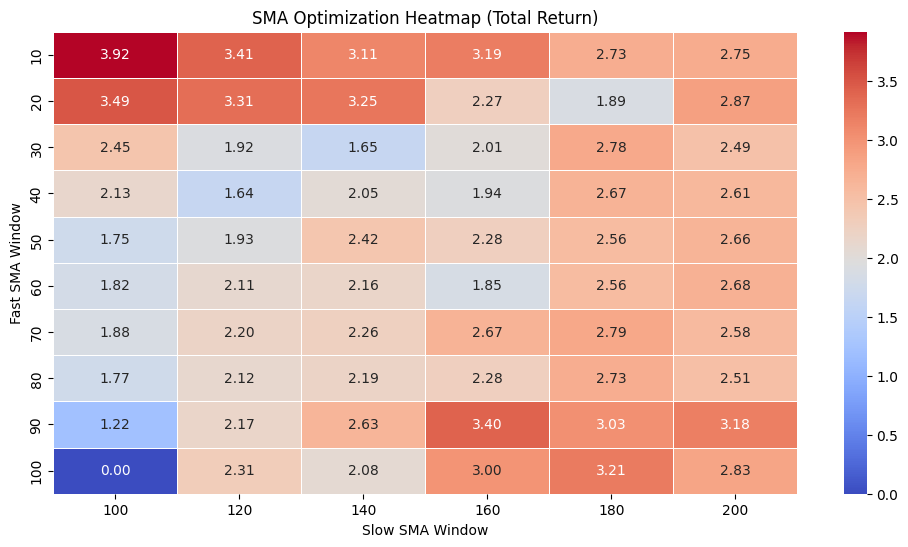

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# Define stock symbol and time period
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download only required columns
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Function to calculate Hilbert Transform Dominant Cycle
def hilbert_dominant_cycle(price_series):
    """Compute Hilbert Transform Dominant Cycle."""
    analytic_signal = hilbert(price_series.dropna())
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    dominant_cycle = np.concatenate(([np.nan], 1 / np.diff(instantaneous_phase)))  # Avoid division by zero
    return pd.Series(dominant_cycle, index=price_series.index).fillna(method='bfill')  # Handle NaNs

# Compute Hilbert Transform Dominant Cycle
df['Hilbert_Dominant_Cycle'] = hilbert_dominant_cycle(df['Close'])

# Define SMA parameter range for optimization
fast_windows = range(1, 201)   # Fast SMA range
slow_windows = range(1, 201)  # Slow SMA range

# Generate all possible parameter combinations
param_combinations = list(itertools.product(fast_windows, slow_windows))

# Store results for different parameter combinations
results = []
returns_matrix = pd.DataFrame(index=fast_windows, columns=slow_windows)

for fast_sma, slow_sma in param_combinations:
    # Compute moving averages
    df['SMA_Fast'] = df['Close'].rolling(window=fast_sma).mean()
    df['SMA_Slow'] = df['Close'].rolling(window=slow_sma).mean()

    # Filter data for the test period (2020-2025)
    df_filter = df[(df.index.year >= 2020) & (df.index.year <= 2025)].copy()

    # Define Entry and Exit signals
    df_filter['Entry'] = (df_filter['Hilbert_Dominant_Cycle'] > df_filter['Hilbert_Dominant_Cycle'].shift(1)) & (df_filter['SMA_Fast'] > df_filter['SMA_Slow'])
    df_filter['Exit'] = (df_filter['Hilbert_Dominant_Cycle'] < df_filter['Hilbert_Dominant_Cycle'].shift(1)) & (df_filter['SMA_Fast'] < df_filter['SMA_Slow'])

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df_filter['Close'],
        entries=df_filter['Entry'],
        exits=df_filter['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    # Store performance metrics
    total_return = portfolio.total_return()
    results.append((fast_sma, slow_sma, total_return))
    returns_matrix.loc[fast_sma, slow_sma] = total_return  # Store for heatmap

# Convert values to numeric
returns_matrix = returns_matrix.astype(float)

# Find the best SMA parameters
best_params = max(results, key=lambda x: x[2])  # Maximize total return
best_fast_sma, best_slow_sma, best_return = best_params

print(f"Best SMA parameters: Fast={best_fast_sma}, Slow={best_slow_sma}, Return={best_return:.2f}%")

# --- Heatmap Visualization ---
plt.figure(figsize=(12, 6))
sns.heatmap(returns_matrix, annot=False, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.xlabel("Slow SMA Window")
plt.ylabel("Fast SMA Window")
plt.title("SMA Optimization Heatmap (Total Return)")
plt.show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-7f7864f9e92b>:25: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Best SMA parameters: Fast=89, Slow=122, Return=0.91


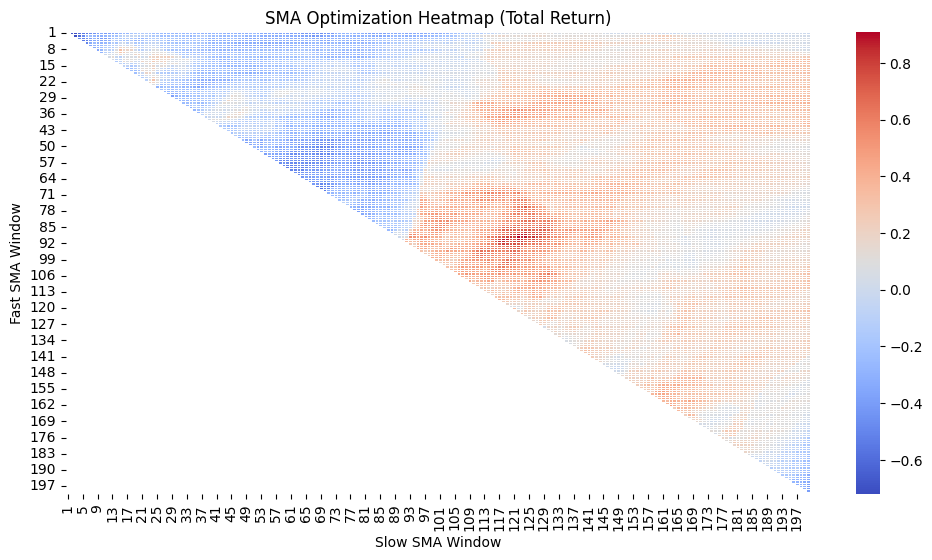

<ipython-input-9-7f7864f9e92b>:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-7f7864f9e92b>:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/sta

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           190871.220807
Total Return [%]                        90.871221
Benchmark Return [%]                     44.11807
Max Gross Exposure [%]                      100.0
Total Fees Paid                       1832.180228
Max Drawdown [%]                        14.639416
Max Drawdown Duration                       419.0
Total Trades                                    6
Total Closed Trades                             5
Total Open Trades                               1
Open Trade PnL                        3593.381555
Win Rate [%]                                 80.0
Best Trade [%]                          52.591343
Worst Trade [%]                         -0.616484
Avg Winning Trade [%]                   18.894109
Avg Losing Trade [%]                    -0.616484


In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# Define stock symbol and time period
symbol = 'YUM'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download only required columns
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Function to calculate Hilbert Transform Dominant Cycle
def hilbert_dominant_cycle(price_series):
    """Compute Hilbert Transform Dominant Cycle."""
    analytic_signal = hilbert(price_series.dropna())
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    dominant_cycle = np.concatenate(([np.nan], 1 / np.diff(instantaneous_phase)))  # Avoid division by zero
    return pd.Series(dominant_cycle, index=price_series.index).fillna(method='bfill')  # Handle NaNs

# Compute Hilbert Transform Dominant Cycle
df['Hilbert_Dominant_Cycle'] = hilbert_dominant_cycle(df['Close'])

# Define SMA parameter range for optimization
fast_windows = range(1, 201)   # Fast SMA range
slow_windows = range(1, 201)   # Slow SMA range

# Generate valid parameter combinations where fast_sma < slow_sma
param_combinations = [(fast, slow) for fast in fast_windows for slow in slow_windows if fast < slow]

# Store results for different parameter combinations
results = []
returns_matrix = pd.DataFrame(index=fast_windows, columns=slow_windows)

for fast_sma, slow_sma in param_combinations:
    # Compute moving averages
    df['SMA_Fast'] = df['Close'].rolling(window=fast_sma).mean()
    df['SMA_Slow'] = df['Close'].rolling(window=slow_sma).mean()

    # Filter data for the test period (2020-2025)
    df_filter = df[(df.index.year >= 2020) & (df.index.year <= 2025)].copy()

    # Define Entry and Exit signals
    df_filter['Entry'] = (df_filter['Hilbert_Dominant_Cycle'] > df_filter['Hilbert_Dominant_Cycle'].shift(1)) & (df_filter['SMA_Fast'] > df_filter['SMA_Slow'])
    df_filter['Exit'] = (df_filter['Hilbert_Dominant_Cycle'] < df_filter['Hilbert_Dominant_Cycle'].shift(1)) & (df_filter['SMA_Fast'] < df_filter['SMA_Slow'])

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df_filter['Close'],
        entries=df_filter['Entry'],
        exits=df_filter['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    # Store performance metrics
    total_return = portfolio.total_return()
    results.append((fast_sma, slow_sma, total_return))
    returns_matrix.loc[fast_sma, slow_sma] = total_return  # Store for heatmap

# Convert values to numeric
returns_matrix = returns_matrix.astype(float)

# Find the best SMA parameters
best_params = max(results, key=lambda x: x[2])  # Maximize total return
best_fast_sma, best_slow_sma, best_return = best_params

print(f"Best SMA parameters: Fast={best_fast_sma}, Slow={best_slow_sma}, Return={best_return:.2f}")

# --- Heatmap Visualization ---
plt.figure(figsize=(12, 6))
sns.heatmap(returns_matrix, annot=False, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.xlabel("Slow SMA Window")
plt.ylabel("Fast SMA Window")
plt.title("SMA Optimization Heatmap (Total Return)")
plt.show()

# Re-run backtest with best parameters
df['SMA_Fast'] = df['Close'].rolling(window=best_fast_sma).mean()
df['SMA_Slow'] = df['Close'].rolling(window=best_slow_sma).mean()

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

df['Entry'] = (df['Hilbert_Dominant_Cycle'] > df['Hilbert_Dominant_Cycle'].shift(1)) & (df['SMA_Fast'] > df['SMA_Slow'])
df['Exit'] = (df['Hilbert_Dominant_Cycle'] < df['Hilbert_Dominant_Cycle'].shift(1)) & (df['SMA_Fast'] < df['SMA_Slow'])

# Final backtest
best_portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

print(best_portfolio.stats())

# Plot the equity curve of the best strategy
best_portfolio.plot().show()

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from scipy.signal import hilbert

# Define the stock symbol and time period
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Function to calculate Hilbert Transform Dominant Cycle
def hilbert_dominant_cycle(price_series):
    """Compute Hilbert Transform Dominant Cycle."""
    analytic_signal = hilbert(price_series)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    dominant_cycle = 1 / np.diff(instantaneous_phase, prepend=instantaneous_phase[0])
    return pd.Series(dominant_cycle, index=price_series.index)

# Function to calculate Exponential Moving Average (EMA)
def calculate_ema(price_series, window):
    """Compute Exponential Moving Average (EMA)."""
    return price_series.ewm(span=window, adjust=False).mean()

# Compute Hilbert Transform Dominant Cycle
df['Hilbert_Dominant_Cycle'] = hilbert_dominant_cycle(df['Close'])

# Compute SMA 50 and SMA 200 manually
df['SMA_Fast'] = df['Close'].rolling(window=50).mean()
df['SMA_Slow'] = df['Close'].rolling(window=200).mean()

# Define Entry and Exit signals
df['Entry'] = (df['Hilbert_Dominant_Cycle'] > df['Hilbert_Dominant_Cycle'].shift(1)) & (df['SMA_Fast'] > df['SMA_Slow'])
df['Exit'] = (df['Hilbert_Dominant_Cycle'] < df['Hilbert_Dominant_Cycle'].shift(1)) & (df['SMA_Fast'] < df['SMA_Slow'])

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

[*********************100%***********************]  1 of 1 completed
<ipython-input-9-30c0bd4e6eb0>:21: RuntimeWarning:

divide by zero encountered in divide

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           364269.747807
Total Return [%]                       264.269748
Benchmark Return [%]                   180.172856
Max Gross Exposure [%]                      100.0
Total Fees Paid                        468.310333
Max Drawdown [%]                        34.592131
Max Drawdown Duration                       382.0
Total Trades                                    3
Total Closed Trades                             2
Total Open Trades                               1
Open Trade PnL                      255992.518689
Win Rate [%]                                 50.0
Best Trade [%]                          42.648301
Worst Trade [%]                        -24.096369
Avg Winning Trade [%]                   42.648301
Avg Losing Trade [%]                   -24.096369
